In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
print(tf.__version__)

2.9.1


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.',
                                 cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [12]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [13]:
train_dir = os.path.join(dataset_dir, 'train')

In [14]:
sample = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [15]:
removeDir = os.path.join(train_dir, 'unsup')
shutil.rmtree(removeDir)

FileNotFoundError: [Errno 2] No such file or directory: './aclImdb/train/unsup'

In [16]:
batchSize = 32
seed = 42
rawTrainDs = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batchSize,
                                                        validation_split=.2,
                                                        subset='training',
                                                        seed=seed)
                                                        

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [17]:
for text_batch, label_batch in rawTrainDs.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [18]:
rawVals = tf.keras.utils.text_dataset_from_directory('aclImdb/train',
                                                     batch_size=batchSize,
                                                     validation_split=.2,
                                                     subset='validation',
                                                     seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [19]:

rawTests = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batchSize)

Found 25000 files belonging to 2 classes.


Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

rawTests = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batchSize)

In [20]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [63]:
maxFeats = 10000
sequenceLength = 250

vectorizeLayer = layers.TextVectorization(standardize=custom_standardization,
                                          max_tokens=maxFeats,
                                          output_mode='int',
                                          output_sequence_length=sequenceLength)



In [64]:

trainText = rawTrainDs.map(lambda x, y:x)
vectorizeLayer.adapt(trainText)

In [65]:
def vectorize_text(text, label):
    print(text.shape)
    text = tf.expand_dims(text, -1)
    print(text.shape)
    return vectorizeLayer(text), label

In [66]:
textBatch, labelBatch = next(iter(rawTrainDs))
firstReview, firstLabel = textBatch[0], labelBatch[0]
print("Vectorized Review", vectorize_text(firstReview, firstLabel))

()
(1,)
Vectorized Review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[2528,   13,    4, 2218,    5,   48,  227,   26,  488,   32,    2,
          83,   86, 1007, 6768, 6996,    5,    2,    1,    3,    9,   13,
         986,  581,   20,  681,  708,    1,   84,    5,    2,  598,    8,
           2, 2174, 1033,   32,    2,  333,   86, 1007, 6768, 6996,   60,
         606,   16, 3114,    3, 5437,  104,  149,  589,   71, 3780,   25,
           8,    2, 4959,    2, 6768, 6887, 1587, 1007,    3,    1,   25,
         986, 1118,  297,  243,   91,  443,   20, 6768, 2630,  129, 1429,
           1,    1,    2,   61,   28,    5,    2, 1539,  653, 2630,   21,
           6,   25,   74,  814, 2353,   37,    2, 6996,  139,  148,   26,
         555,   57,  803,  189,   47,   76,   26,   50,    6,  203,    8,
           2,  781,  701,   47,    7,  101,   30,   39, 3697,  115,    3,
           1,    1,    2,  350,    1,  729, 2744,    3,  282, 1116,   43,
           1,    1, 4055,    6,   39,

In [102]:
print("1287 ---> ",vectorizeLayer.get_vocabulary()[1287])
print("313 ---> ",vectorizeLayer.get_vocabulary()[3])
print('Vocab size: {}'.format(len(vectorizeLayer.get_vocabulary())))



1287 --->  silent
313 --->  and
Vocab size: 10000


In [67]:
trainDs = rawTrainDs.map(vectorize_text)
valDs = rawVals.map(vectorize_text)
testDs = rawTests.map(vectorize_text)

(None,)
(None, 1)
(None,)
(None, 1)
(None,)
(None, 1)


In [116]:
autoTune = tf.data.AUTOTUNE
trainDs = trainDs.cache().prefetch(buffer_size=autoTune)
valDs = valDs.cache().prefetch(buffer_size=autoTune)
testDs = testDs.cache().prefetch(buffer_size=autoTune)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 64)          640000    
                                                                 
 dropout_32 (Dropout)        (None, None, 64)          0         
                                                                 
 global_average_pooling1d_15  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_______________________________________________

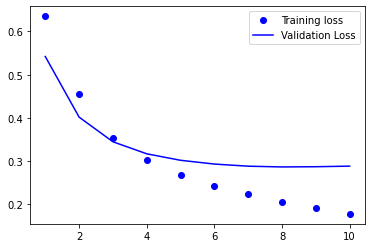

In [119]:
embeddingDim = 64
model = tf.keras.Sequential([
    layers.Embedding(maxFeats, embeddingDim),
    layers.Dropout(0.1),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.5),
    layers.Dense(1)])
model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),optimizer = 'adam', 
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(trainDs, validation_data=valDs, epochs=epochs,callbacks=[callback, tensorboard_callback])

loss, acc = model.evaluate(testDs)
print('loss: ', loss,'\nAccuracy :', acc)

historyDict = history.history
historyDict.keys()

acc = historyDict['binary_accuracy']
val_acc = historyDict['val_binary_accuracy']
loss = historyDict['loss']
val_loss = historyDict['val_loss']

epochs = range(1, len(acc) +1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.show()

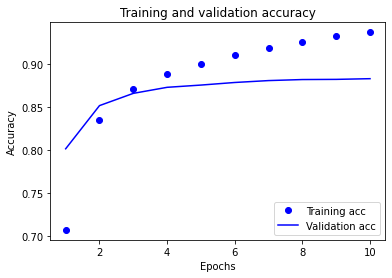

In [120]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [122]:
%load_ext tensorboard
%tensorboard --logdir logs

In [103]:
exportModel = tf.keras.Sequential([
        vectorizeLayer,
    model,
    layers.Activation('sigmoid')
])
exportModel.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])
loss, accuracy = exportModel.evaluate(rawTests)
print(accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3130 - accuracy: 0.8729
0.8729199767112732


In [112]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
    "I loved this movie, it was fantastic",
    "fuck this movie"
]

res = exportModel.predict(examples)

1/1 [==============================] - 0s 39ms/step


In [113]:
res.round()

array([[1.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)